## Lagrangian diagnostics computation

This notebook provides a tutorial to compute **Lagrangian diagnostics** from velocity fields, including:

- Finite-Time Lyapunov Exponents (**FTLE**)
- Longitude/Latitude advection (**LLADV**)
- Sea Surface Temperature advection (**SSTADV**)
- Retention parameter (**OWTRAJ**)
- Lithogenic water mass age and transit (**TIMEFROMBATHY**)

The `Diagnostics.Lagrangian` class contains the core methods to:

- Advect particles (time integration schemes, interpolation methods)
- Loop over one or several diagnostics (`diag`)
- Compute the diagnostics listed above

`Diagnostics.Lagrangian` first computes **Lagrangian trajectories once**, and then derives all requested diagnostics from these trajectories.

---

### How to run

Particles should first be defined using the child class `ParticleSet`
(see `ParticleSet.ipynb`).

The `ParticleSet` object — which contains velocity fields and particle parameters —
is then used to compute Lagrangian trajectories and derived diagnostics:

```python
pset = Diagnostics.ParticleSet.from_XXX(args, **kwargs)
out = pset.diag(diag=[...], args, **kwargs)
```

---

### Lagrangian diagnostics setup

Lagrangian diagnostics are usually computed with particles seeded over a  
**regular grid** in order to produce spatial maps  
(using `ParticleSet.from_grid()`).

However, users are free to use other particle samplings.

---

### Inputs

- Inputs for `ParticleSet` are defined in `ParticleSet.ipynb`
- **`diag`**: list of diagnostics to be computed
- **`method`**: iterative method  
  (must have the same nomenclature as defined in `Diagnostics.py`)
- **`f`**: interpolation method  
  (`Lagrangian.XXX` in `Diagnostics.py`)
- **`numstep`**: step for the iterative method
- **`coordinates`**: `"spherical"` if working on Earth coordinates
- **`numdays`**: number of days for particle advection
- **`dayv`**: first day of advection (`"%Y-%m-%d"`)

---

### Outputs

- **`out`**: array containing all diagnostics and associated variables

Example structure:

- **`out[0]`**: first diagnostic  
  - `out[0]['lon']`, `out[0]['lat']`, `out[0]['var0']`
- **`out[1]`**: second diagnostic (if applicable)  
  - `out[1]['lon']`, `out[1]['lat']`, `out[1]['var1']`


:::{note}
This notebook is rendered on Read the Docs using **precomputed outputs**.
To rerun the analysis, execute the notebook locally.
:::

### Import libraries

In [1]:
from lamta.Diagnostics import ParticleSet, Lagrangian
from lamta.Save import Create
from lamta.Load_nc import loadCMEMSuv,loadsst, loadbathy
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm_oc

import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Fetch data

This notebook uses reference datasets distributed via the **LAMTA examples data (v0.1)** GitHub release.
The data are downloaded automatically at runtime using `pooch` and are not stored in the repository.
Notebooks shown on Read the Docs use precomputed outputs.
To modify parameters or recompute results, run this notebook locally.

Documentation: https://lamta-examples.readthedocs.io/en/latest/


In [2]:
from lamta_examples.data_fetch import ensure_dataset, repo_root

DATA_DIR = ensure_dataset("altimetry_nrt_global_20220909-20220929.tar.gz")
rep = str(DATA_DIR / "altimetry" / "nrt_global") + "/"


## Definition of variables

In [3]:
# load field from netcdf
all_days = ['20220912','20220913','20220914','20220915','20220916','20220917','20220918','20220919','20220920','20220921','20220922','20220923','20220924','20220925','20220926','20220927','20220928','20220929']

varn = {'longitude':'longitude','latitude':'latitude','u':'ugos','v':'vgos'}
field = loadCMEMSuv(all_days,rep,varn,unit='deg/d')

# Set particles along a regular grid
numdays = 15
loni = [-2,9]
lati = [35.5,44.5]
delta0 = 0.05
dayv = '2022-09-29'
step = 10

pset = ParticleSet.from_grid(numdays,loni,lati,delta0,dayv,fieldset=field,mode='backward')

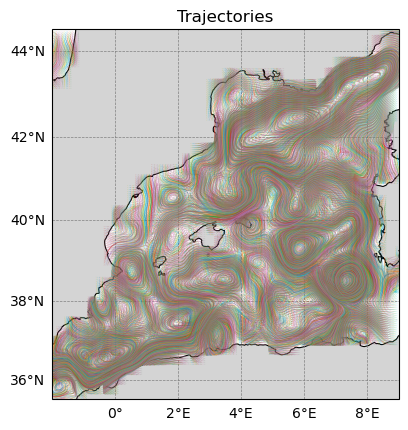

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.ticker import MultipleLocator

# Compute trajectories only (no diagnostics)
out = pset.diag(
    diag=None,
    method="rk4flat",
    f=Lagrangian.interpf,
    numstep=step,
    coordinates="spherical",
    numdays=numdays,
    dayv=dayv,
)

trjf = out[0]

# Plot trajectories with Cartopy
lon_min, lon_max = loni[0], loni[1]
lat_min, lat_max = lati[0], lati[1]

fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=0)
ax.add_feature(cfeature.LAND, facecolor="0.83", edgecolor="none", zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    linestyle="--",
    color="0.5",
)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = MultipleLocator(2)
gl.ylocator = MultipleLocator(2)

x = np.asarray(trjf["trjx"])
y = np.asarray(trjf["trjy"])

# Ensure shape is (ntime, ntraj)
if x.ndim == 2 and y.ndim == 2:
    if x.shape[0] < x.shape[1]:
        xt, yt = x, y
    else:
        xt, yt = x.T, y.T
else:
    raise ValueError("Expected 2D trajectories arrays for trjx/trjy.")

# Break lines at NaNs (no spurious connections)
mask = np.isfinite(xt) & np.isfinite(yt)
xt = np.where(mask, xt, np.nan)
yt = np.where(mask, yt, np.nan)

ax.plot(
    xt, yt,
    transform=ccrs.PlateCarree(),
    linewidth=0.4,
    alpha=0.25,
)

ax.set_title("Trajectories")
plt.show()


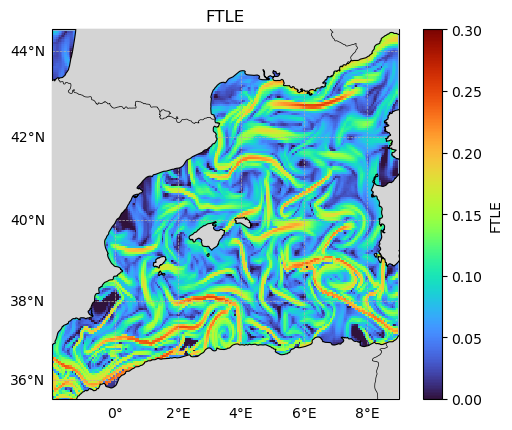

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Compute FTLE from previous trajectories (no trajectory recomputation)
domain = ParticleSet(loni=loni, lati=lati)  # define domain only
ftle = domain.FTLE(trjf, numdays=numdays, dayv=dayv)

# Prepare grid
X, Y = np.meshgrid(ftle["lons"], ftle["lats"])  # lon/lat grid
Z = np.asarray(ftle["ftle"])                   # FTLE values

# Plot FTLE with Cartopy
fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())

ax.set_extent([loni[0], loni[1], lati[0], lati[1]], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, facecolor="0.83", zorder=3)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=4)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=4)

pcm = ax.pcolormesh(
    X, Y, Z,
    transform=ccrs.PlateCarree(),
    cmap="turbo",
    vmin=0, vmax=0.3,
    zorder=1,
    shading="auto",
)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    linestyle="--",
    zorder=5,
)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = plt.MultipleLocator(2)
gl.ylocator = plt.MultipleLocator(2)

plt.colorbar(pcm, ax=ax, label="FTLE")
ax.set_title("FTLE")
plt.show()


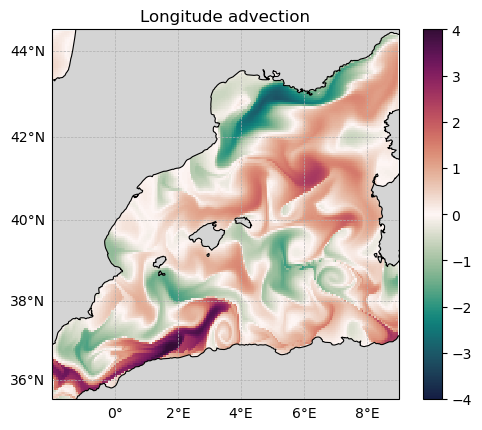

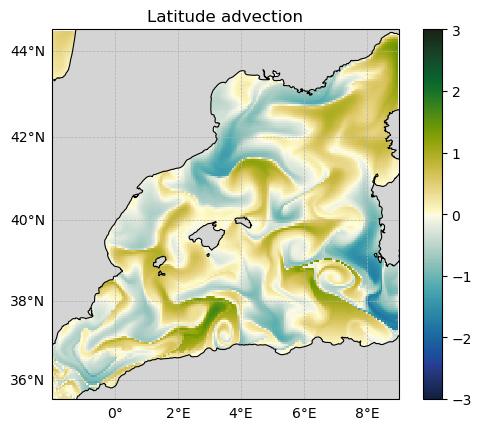

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Compute Lon/Lat advection from previous trajectories
lladv = domain.LLADV(trjf, numdays=numdays, dayv=dayv)

# plot longitude advection (LLADV)
fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())

ax.set_extent([loni[0], loni[1], lati[0], lati[1]], crs=ccrs.PlateCarree())

X, Y = np.meshgrid(lladv["lons"], lladv["lats"])

pcm = ax.pcolormesh(
    X, Y, lladv["lonf_map"],
    transform=ccrs.PlateCarree(),
    cmap=cm_oc.cm.curl,
    vmin=-4, vmax=4,
    shading="auto",
    zorder=1,
)

ax.add_feature(cfeature.LAND, facecolor="0.83", zorder=2)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=3)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    linestyle="--",
)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = plt.MultipleLocator(2)
gl.ylocator = plt.MultipleLocator(2)

plt.colorbar(pcm, ax=ax)
ax.set_title("Longitude advection")
plt.show()

# plot latitude advection (LLADV)
fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())

ax.set_extent([loni[0], loni[1], lati[0], lati[1]], crs=ccrs.PlateCarree())

X, Y = np.meshgrid(lladv["lons"], lladv["lats"])

pcm = ax.pcolormesh(
    X, Y, lladv["latf_map"],
    transform=ccrs.PlateCarree(),
    cmap=cm_oc.cm.delta,
    vmin=-3, vmax=3,
    shading="auto",
    zorder=1,
)

ax.add_feature(cfeature.LAND, facecolor="0.83", zorder=2)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=3)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    linestyle="--",
)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = plt.MultipleLocator(2)
gl.ylocator = plt.MultipleLocator(2)

plt.colorbar(pcm, ax=ax)
ax.set_title("Latitude advection")
plt.show()

In [7]:
from pathlib import Path

outdir = Path("..") / "outputs"
outdir.mkdir(parents=True, exist_ok=True)

# Save previous outputs in netcdf files
fname = outdir / "FTLE_test.nc"
title = "FTLE 2022-09-29"
var_name = "ftle"
var_units = "d^{-1}"
Create.netcdf(str(fname), ftle["lons"], ftle["lats"], ftle["ftle"], title, var_name, var_units)

Create.netcdf(
    str(outdir / "LLADV_test.nc"),
    lladv["lons"], lladv["lats"], lladv["lonf_map"],
    "LLADV 2022-09-29", "lonf_map", "degreeE",
    var2=lladv["latf_map"], var2_name="latf_map", var2_units="degreeN",
)

## Compute trajectories and all diagnostics at once

In [8]:
# 1) Ensure the SST dataset bundle is present
DATA_DIR = ensure_dataset("sst_ostia_slstr_samples.tar.gz")

# 2) Point rep to the OSTIA folder
rep_sst = str(DATA_DIR / "sst" / "ostia") + "/"

# 3) Load SST
sstname = "20230109120000-UKMO-L4_GHRSST-SSTfnd-OSTIA-GLOB-v02.0-fv02.0.nc"
sstfield = loadsst(sstname, rep_sst)

# additional parameters
bathylvl = -700 # in meters

# Ensure bathymetry bundle is available
DATA_DIR = ensure_dataset("bathymetry_etopo_medsea.tar.gz")

# Point to the correct subfolder
rep_bathy = str(DATA_DIR / "bathymetry") + "/"

# Load bathymetry
bathyname = "ETOPO_2022_v1_30s_N90W180_bed_MedSea.nc"
bfield = loadbathy(
    bathyname,
    rep_bathy,
    rlon=loni,
    rlat=lati,
)

# Lagrangian diagnostics computation
out = pset.diag(diag=['LLADV','FTLE','OWTRAJ','SSTADV','TIMEFROMBATHY'],method='rk4flat',
                f=Lagrangian.interpf,numstep=step,
                coordinates='spherical',numdays=numdays,dayv=dayv,
                ds=1/6,sstfield=sstfield,bathyfield=bfield,
                bathylvl=bathylvl)

trjf = out[0]
lladv = out[1]
ftle = out[2]
owdisp = out[3]
sstadv = out[4]
timfb = out[5]

C:\Users\lloyd\Desktop\lagrangian_dev\LAMTA\lamta\Diagnostics.py:494: UserWarning: Warning: 'daysst' is not defined -> using default value (3)
  warnings.warn("Warning: 'daysst' is not defined -> using default value (3)")


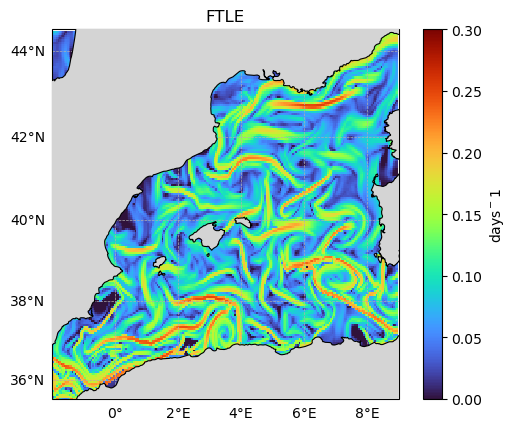

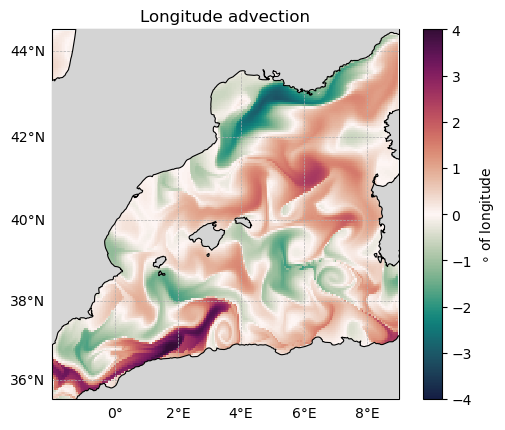

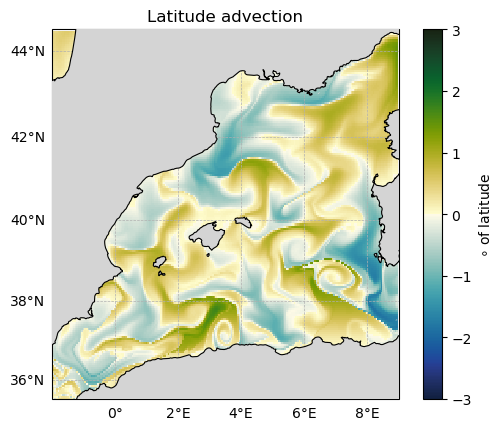

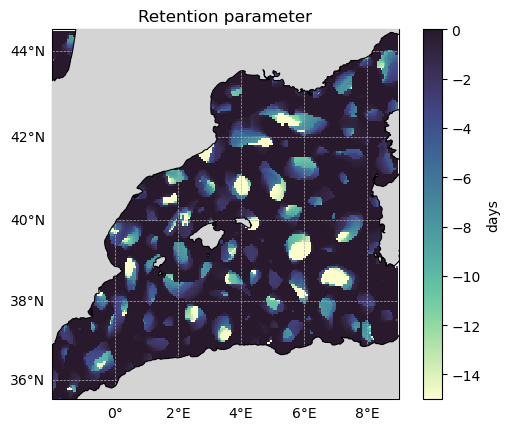

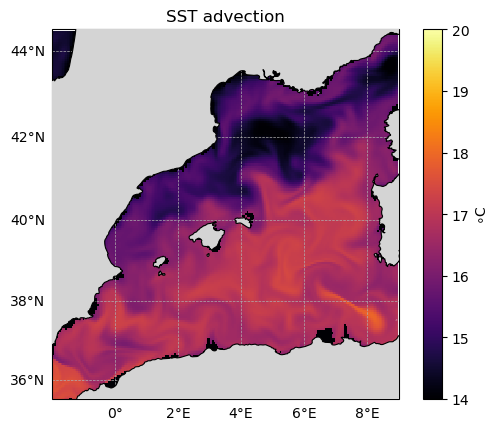

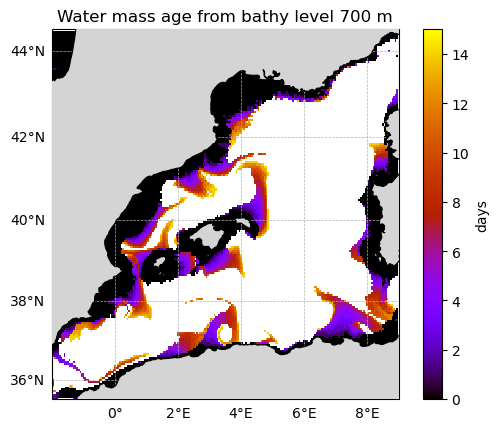

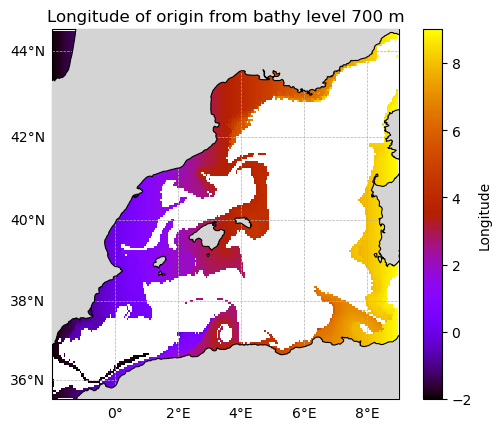

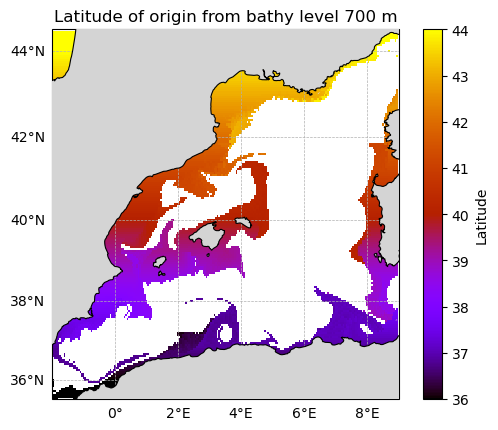

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def _cartopy_base_ax(loni, lati):
    """Create a Cartopy Mercator axes with the same extent and labelled gridlines."""
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.Mercator())
    ax.set_extent([loni[0], loni[1], lati[0], lati[1]], crs=ccrs.PlateCarree())

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5,
        linestyle="--",
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = plt.MultipleLocator(2)
    gl.ylocator = plt.MultipleLocator(2)

    return fig, ax


def _cartopy_pcolormesh(ax, lons, lats, field, **kwargs):
    """pcolormesh in lon/lat coords (PlateCarree) onto a projected axes."""
    X, Y = np.meshgrid(lons, lats)
    return ax.pcolormesh(
        X, Y, field,
        transform=ccrs.PlateCarree(),
        shading="auto",
        **kwargs,
    )


def _add_continents_on_top(ax, facecolor="0.83"):
    """Add land/coastlines above data (continents on top)."""
    # Land on top of the raster
    ax.add_feature(cfeature.LAND, facecolor=facecolor, zorder=100)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=101)


# plot FTLE
fig, ax = _cartopy_base_ax(loni, lati)
pcm = _cartopy_pcolormesh(
    ax, ftle["lons"], ftle["lats"], ftle["ftle"],
    cmap="turbo", zorder=-1, vmin=0, vmax=0.3,
)
_add_continents_on_top(ax, facecolor="0.83")
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label("days$^-{1}$")
plt.title("FTLE")
plt.show()


# plot LLADV
fig, ax = _cartopy_base_ax(loni, lati)
pcm = _cartopy_pcolormesh(
    ax, lladv["lons"], lladv["lats"], lladv["lonf_map"],
    cmap=cm_oc.cm.curl, zorder=-1, vmin=-4, vmax=4,
)
_add_continents_on_top(ax, facecolor="0.83")
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label("$\\circ$ of longitude")
plt.title("Longitude advection")
plt.show()

fig, ax = _cartopy_base_ax(loni, lati)
pcm = _cartopy_pcolormesh(
    ax, lladv["lons"], lladv["lats"], lladv["latf_map"],
    cmap=cm_oc.cm.delta, zorder=-1, vmin=-3, vmax=3,
)
_add_continents_on_top(ax, facecolor="0.83")
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label("$\\circ$ of latitude")
plt.title("Latitude advection")
plt.show()

# plot Retention parameter
fig, ax = _cartopy_base_ax(loni, lati)
pcm = _cartopy_pcolormesh(
    ax, owdisp["lons"], owdisp["lats"], owdisp["owdisp"],
    cmap=cm_oc.cm.deep, zorder=-1, vmin=-15, vmax=0,
)
_add_continents_on_top(ax, facecolor="0.83")
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label("days")
plt.title("Retention parameter")
plt.show()

# plot SST advection
fig, ax = _cartopy_base_ax(loni, lati)
pcm = _cartopy_pcolormesh(
    ax, sstadv["lons"], sstadv["lats"], sstadv["sstadv"],
    cmap="inferno", zorder=-1, vmin=14, vmax=20,
)
_add_continents_on_top(ax, facecolor="0.83")
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label("$\\circ$C")
plt.title("SST advection")
plt.show()


# plot time from bathy (water mass age)
fig, ax = _cartopy_base_ax(loni, lati)
pcm = _cartopy_pcolormesh(
    ax, timfb["lons"], timfb["lats"], timfb["timfb"],
    cmap="gnuplot", zorder=-1, vmin=0, vmax=15,
)
_add_continents_on_top(ax, facecolor="0.83")
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label("days")
plt.title("Water mass age from bathy level 700 m")
plt.show()

# plot longitude from bathy (transit)
fig, ax = _cartopy_base_ax(loni, lati)
pcm = _cartopy_pcolormesh(
    ax, timfb["lons"], timfb["lats"], timfb["lonfb"],
    cmap="gnuplot", zorder=-1, vmin=-2, vmax=9,
)
_add_continents_on_top(ax, facecolor="0.83")
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label("Longitude")
plt.title("Longitude of origin from bathy level 700 m")
plt.show()


# plot latitude from bathy (transit)
fig, ax = _cartopy_base_ax(loni, lati)
pcm = _cartopy_pcolormesh(
    ax, timfb["lons"], timfb["lats"], timfb["latfb"],
    cmap="gnuplot", zorder=-1, vmin=36, vmax=44,
)
_add_continents_on_top(ax, facecolor="0.83")
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label("Latitude")
plt.title("Latitude of origin from bathy level 700 m")
plt.show()
